Study Planner — Multi-Agent Capstone
- Course: Google 5-Day AI Agents Intensive (Capstone)
- Author: Kanishka Sejwal
- Goal: Build a multi-agent Study Planner that generates a 30-day personalized timetable (3 hr/day), tracks daily progress, and adapts using memory.

Notebook contents

- Overview & how to run
- Planner, Scheduler, Memory, Evaluator implementations (prototype)
- Orchestrator to run simulation and interactive check-ins
- How to record demo and submission checklist

Quick run instructions
- Runtime: Python 3.x (Kaggle default works).
- To run a simulated 7-day demo: run all cells and in the final orchestration cell set interactive=False (default).
- To run interactive check-ins: set interactive=True. The evaluator will ask y/n for each slot.
- The notebook will create study_memory.json to store plan & progress.

In [1]:
# Imports & basic helpers
import json, os, datetime, uuid, math
from typing import List, Dict, Any
from dataclasses import dataclass
print("Ready — imports successful.")

Ready — imports successful.


User profile (edit this cell with your inputs)
- Update this cell to reflect the student's subjects, days, daily hours and difficulty.

We will use these defaults from your inputs:

* Subjects: Maths, Science, Programming, English, Social, Telugu, Hindi
* Days: 30
* Daily hours: 3
* Difficulty: Maths/Science/Programming = hard; Social/Telugu/Hindi = medium;  English = easy

In [16]:
# === User profile (customize if you want) ===
USER_PROFILE = {
    "subjects": ["Maths","Science","Programming","English","Social","Telugu","Hindi", "History", "Art"], # Added History and Art
    "days": 30,
    "daily_hours": 3,
    "difficulty": {
        "Maths":"hard","Science":"hard","Programming":"hard",
        "English":"easy","Social":"medium","Telugu":"medium","Hindi":"medium",
        "History":"medium","Art":"easy" # Added difficulty for History and Art
    },
    # optional: supply a custom topic bank to override defaults
    "topic_bank": {
        # "Maths": ["Arithmetic","Algebra","Geometry"]  # example override
    }
}
print("USER_PROFILE set. Subjects:", USER_PROFILE["subjects"])

USER_PROFILE set. Subjects: ['Maths', 'Science', 'Programming', 'English', 'Social', 'Telugu', 'Hindi', 'History', 'Art']


Memory store
: A small disk-backed memory (study_memory.json) that saves:

* generated plan
* schedule
* daily progress
~ This simulates the memory tool (replace with ADK memory in final integration).

In [17]:
# Memory store (file-backed)
class MemoryStore:
    def __init__(self, path="study_memory.json"):
        self.path = path
        if os.path.exists(path):
            try:
                with open(path, "r") as f:
                    self.data = json.load(f)
            except Exception:
                self.data = {"runs": [], "plan": None, "schedule": None, "progress": {}}
        else:
            self.data = {"runs": [], "plan": None, "schedule": None, "progress": {}}
            self._save()
    def _save(self):
        with open(self.path, "w") as f:
            json.dump(self.data, f, indent=2)
    def save_plan(self, plan, schedule):
        self.data["plan"] = plan
        self.data["schedule"] = schedule
        self._save()
    def add_run(self, run):
        self.data["runs"].append(run); self._save()
    def update_progress(self, day, record):
        self.data["progress"].setdefault(str(day), []).append(record); self._save()
    def get_progress(self):
        return self.data["progress"]
    def path_exists(self):
        return os.path.exists(self.path)

        # quick check
mem = MemoryStore()
print("Memory file:", mem.path, "exists:", mem.path_exists())


Memory file: study_memory.json exists: True


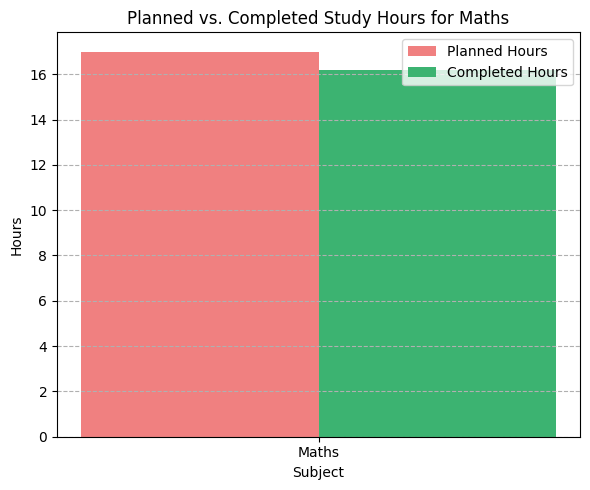

Planned vs. completed hours plot for 'Maths' generated.


In [20]:
import numpy as np

# --- 3. Extract Subject-wise Progress for 'Maths' ---
maths_planned_hours = data["plan"]["subject_hours"].get("Maths", 0)
maths_completed_minutes = 0

for day_str, records in data["progress"].items():
    for record in records:
        for slot in record["slots"]:
            if slot["subject"] == "Maths" and slot["completed"]:
                maths_completed_minutes += slot["mins"]

maths_completed_hours = maths_completed_minutes / 60

# --- 4. Plot Planned vs. Completed for 'Maths' ---
x = np.arange(1) # Only one subject for this plot
width = 0.35

plt.figure(figsize=(6, 5))
plt.bar(x - width/2, [maths_planned_hours], width, label='Planned Hours', color='lightcoral')
plt.bar(x + width/2, [maths_completed_hours], width, label='Completed Hours', color='mediumseagreen')

plt.title('Planned vs. Completed Study Hours for Maths')
plt.xlabel('Subject')
plt.ylabel('Hours')
plt.xticks(x, ['Maths'])
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
print("Planned vs. completed hours plot for 'Maths' generated.")

## Visualize 'Maths' Subject Progress

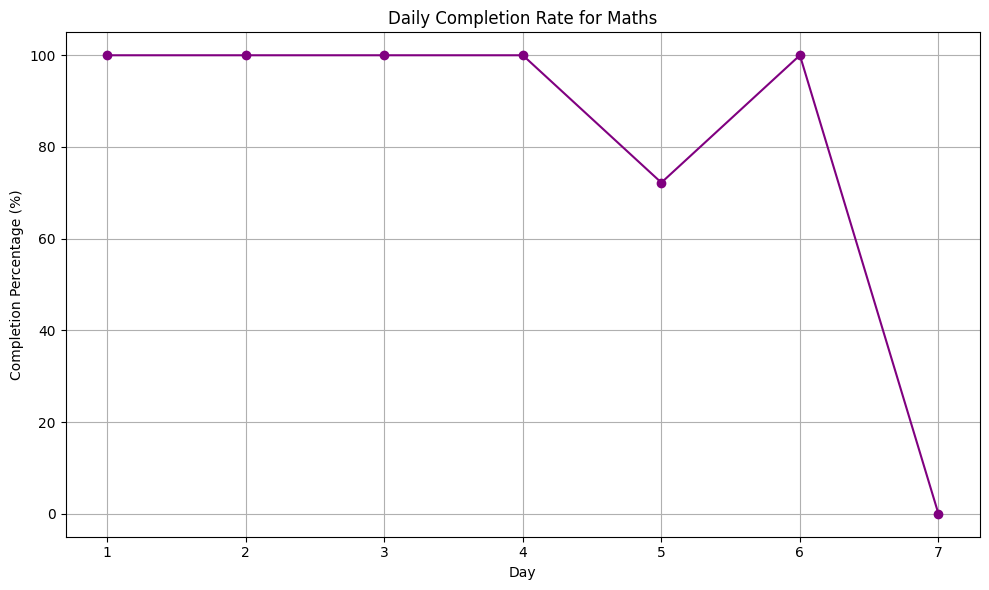

Daily completion rate plot for 'Maths' generated.


In [18]:
import matplotlib.pyplot as plt

# --- 1. Extract Daily Completion for 'Maths' ---
maths_daily_completion_rates = {}
for day_str, records in data["progress"].items():
    day = int(day_str)
    total_scheduled_minutes_maths = 0
    total_completed_minutes_maths = 0
    for record in records:
        for slot in record["slots"]:
            if slot["subject"] == "Maths":
                total_scheduled_minutes_maths += slot["mins"]
                if slot["completed"]:
                    total_completed_minutes_maths += slot["mins"]

    completion_percentage_maths = (total_completed_minutes_maths / total_scheduled_minutes_maths * 100) if total_scheduled_minutes_maths > 0 else 0
    maths_daily_completion_rates[day] = completion_percentage_maths

maths_days_completed = sorted(maths_daily_completion_rates.keys())
maths_completion_percentages = [maths_daily_completion_rates[d] for d in maths_days_completed]

# --- 2. Plot Daily Completion Rate for 'Maths' ---
plt.figure(figsize=(10, 6))
plt.plot(maths_days_completed, maths_completion_percentages, marker='o', linestyle='-', color='purple')
plt.title('Daily Completion Rate for Maths')
plt.xlabel('Day')
plt.ylabel('Completion Percentage (%)')
plt.xticks(maths_days_completed)
plt.grid(True)
plt.tight_layout()
plt.show()
print("Daily completion rate plot for 'Maths' generated.")

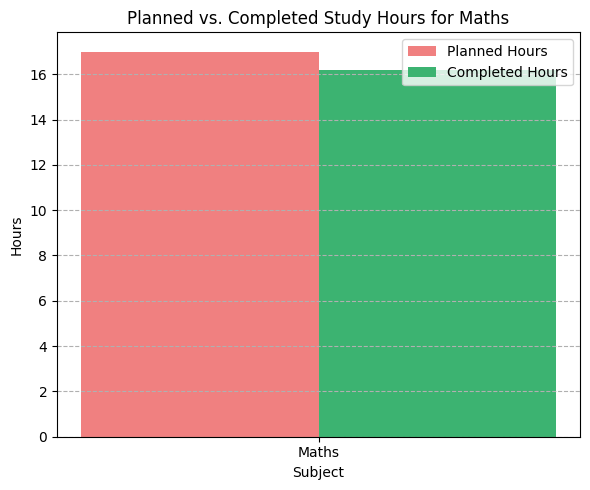

Planned vs. completed hours plot for 'Maths' generated.


In [19]:
import numpy as np

# --- 3. Extract Subject-wise Progress for 'Maths' ---
maths_planned_hours = data["plan"]["subject_hours"].get("Maths", 0)
maths_completed_minutes = 0

for day_str, records in data["progress"].items():
    for record in records:
        for slot in record["slots"]:
            if slot["subject"] == "Maths" and slot["completed"]:
                maths_completed_minutes += slot["mins"]

maths_completed_hours = maths_completed_minutes / 60

# --- 4. Plot Planned vs. Completed for 'Maths' ---
x = np.arange(1) # Only one subject for this plot
width = 0.35

plt.figure(figsize=(6, 5))
plt.bar(x - width/2, [maths_planned_hours], width, label='Planned Hours', color='lightcoral')
plt.bar(x + width/2, [maths_completed_hours], width, label='Completed Hours', color='mediumseagreen')

plt.title('Planned vs. Completed Study Hours for Maths')
plt.xlabel('Subject')
plt.ylabel('Hours')
plt.xticks(x, ['Maths'])
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
print("Planned vs. completed hours plot for 'Maths' generated.")

Planner Agent
* Allocates total hours across subjects by difficulty weights.
* Splits hours into topics (topic bank).
* Outputs plan = {subject_hours, topics}.

In [5]:
import json, os, datetime, uuid, math
from typing import List, Dict, Any
from dataclasses import dataclass
# Planner Agent (prototype)
TOPICS_BANK = {
    "Maths":["Arithmetic & Number Sense","Fractions & Decimals","Algebra basics","Geometry basics","Word problems","Revision"],
    "Science":["Biology basics","Physics basics","Chemistry basics","Experiments & application","Revision"],
    "Programming":["Syntax & variables","Control flow","Functions & modularity","Data types & structures","Small projects & debugging","Revision"],
    "English":["Grammar basics","Reading comprehension","Writing & sentences","Vocabulary & spelling","Practice"],
    "Social":["History basics","Civics basics","Geography basics","Maps & current events","Revision"],
    "Telugu":["Reading & comprehension","Grammar basics","Writing practice","Vocabulary","Short passages"],
    "Hindi":["Reading & comprehension","Grammar basics","Writing practice","Vocabulary","Short passages"]
}

class PlannerAgent:
    def __init__(self, memory: MemoryStore):
        self.mem = memory
    def allocate_hours(self, total_hours, difficulty_map):
        weights={"hard":3,"medium":2,"easy":1}
        subj_weights = {s: weights.get(difficulty_map.get(s,"medium"),2) for s in difficulty_map}
        total_w = sum(subj_weights.values())
        unit = total_hours / total_w
        subj_hours = {s: round(unit * w) for s,w in subj_weights.items()}
        # fix rounding to match total_hours
        diff = int(total_hours - sum(subj_hours.values()))
        subs_sorted = sorted(subj_hours.keys(), key=lambda s: subj_weights[s], reverse=True)
        i = 0
        while diff != 0:
            subj_hours[subs_sorted[i % len(subs_sorted)]] += (1 if diff > 0 else -1)
            diff += -1 if diff > 0 else 1
            i += 1
        return subj_hours

    def plan(self, user_profile):
        total_hours = user_profile["days"] * user_profile["daily_hours"]
        subj_hours = self.allocate_hours(total_hours, user_profile["difficulty"])
        topics_map = {}
        for s,h in subj_hours.items():
            bank = user_profile.get("topic_bank", {}).get(s, TOPICS_BANK.get(s, [s+" - General"]))
            per_topic = round(h / len(bank), 2) if len(bank) > 0 else h
            topics_map[s] = [{"name": t, "est_hours": per_topic} for t in bank]
        plan = {"subject_hours": subj_hours, "topics": topics_map}
        return plan

# quick planner demo
planner = PlannerAgent(mem)
sample_plan = planner.plan(USER_PROFILE)
print("Planner sample subject_hours:", sample_plan["subject_hours"])

Planner sample subject_hours: {'Maths': 17, 'Science': 17, 'Programming': 17, 'English': 6, 'Social': 11, 'Telugu': 11, 'Hindi': 11}


Scheduler Agent
* Converts topic hours → minute buckets and distributes them across days.
* Caps single slot to 60 minutes (variety).
* Produces schedule: dict day -> list of slots {subject, topic, mins}.

In [6]:
# Scheduler Agent
class SchedulerAgent:
    def __init__(self, memory: MemoryStore):
        self.mem = memory
    def schedule(self, plan: Dict[str,Any], days:int, daily_hours:int):
        daily_minutes = daily_hours * 60
        schedule = {d: [] for d in range(1, days+1)}
        flattened = []
        for s, topics in plan["topics"].items():
            for t in topics:
                mins = int(round(t["est_hours"] * 60))
                flattened.append({"subject": s, "topic": t["name"], "mins": max(15, mins)})
        cur_day = 1
        for item in flattened:
            while item["mins"] > 0 and cur_day <= days:
                used = sum(x["mins"] for x in schedule[cur_day])
                free = daily_minutes - used
                if free <= 0:
                    cur_day += 1
                    continue
                take = min(free, min(60, item["mins"]))
                schedule[cur_day].append({"subject": item["subject"], "topic": item["topic"], "mins": take})
                item["mins"] -= take
        # save to memory
        self.mem.save_plan(plan, schedule)
        return schedule

        # quick scheduler demo
scheduler = SchedulerAgent(mem)
sample_schedule = scheduler.schedule(sample_plan, USER_PROFILE["days"], USER_PROFILE["daily_hours"])
print("Day 1 sample slots:", sample_schedule[1][:5])


Day 1 sample slots: [{'subject': 'Maths', 'topic': 'Arithmetic & Number Sense', 'mins': 60}, {'subject': 'Maths', 'topic': 'Arithmetic & Number Sense', 'mins': 60}, {'subject': 'Maths', 'topic': 'Arithmetic & Number Sense', 'mins': 50}, {'subject': 'Maths', 'topic': 'Fractions & Decimals', 'mins': 10}]


Evaluator Agent
- Handles daily check-ins (interactive or simulated).
- Stores daily completion records in memory.
- Suggests replan if completion % is low.

In [7]:
# Evaluator Agent
class EvaluatorAgent:
    def __init__(self, memory: MemoryStore):
        self.mem = memory
    def simulated_checkin(self, day:int, day_slots:List[Dict[str,Any]]):
        completed=[]
        for s in day_slots:
            ok = s["mins"] <= 45 or (hash(s["topic"]+str(day)) % 10) < 8
            completed.append({"subject": s["subject"], "topic": s["topic"], "mins": s["mins"], "completed": ok})
        self.mem.update_progress(day, {"slots": completed, "timestamp": str(datetime.datetime.now())})
        return completed
    def interactive_checkin(self, day:int, day_slots:List[Dict[str,Any]]):
        print(f"\nDay {day} check-in (interactive). Please reply 'y' or 'n'.")
        completed=[]
        for i,s in enumerate(day_slots, start=1):
            resp = input(f"[{i}] {s['subject']} - {s['topic']} ({s['mins']} min) - Completed? (y/n): ").strip().lower()
            ok = resp == 'y'
            completed.append({"subject": s["subject"], "topic": s["topic"], "mins": s["mins"], "completed": ok})
        self.mem.update_progress(day, {"slots": completed, "timestamp": str(datetime.datetime.now())})
        return completed

Orchestrator
- Executes Planner → Scheduler → daily loop (Evaluator check-ins)
- Saves runs to memory
- Supports simulated and interactive modes

In [8]:
# ============================
# REQUIRED IMPORTS
# ============================
import uuid
import datetime
from typing import Dict, Any

# Make sure these classes are already defined:
# PlannerAgent, SchedulerAgent, EvaluatorAgent, Memory
# Example: planner = PlannerAgent(mem)

# ============================
# ORCHESTRATOR CLASS
# ============================

class Orchestrator:
    def __init__(self, planner, scheduler, evaluator, memory):
        self.planner = planner
        self.scheduler = scheduler
        self.evaluator = evaluator
        self.mem = memory

    def run(self, user_profile: Dict[str,Any], interactive: bool=False, simulate_days: int=7):
        # Step 1: Generate plan
        plan = self.planner.plan(user_profile)

        # Step 2: Generate schedule
        schedule = self.scheduler.schedule(
            plan,
            user_profile["days"],
            user_profile["daily_hours"]
        )

        # Step 3: Save run metadata
        run_id = str(uuid.uuid4())[:8]
        self.mem.add_run({
            "id": run_id,
            "created": str(datetime.datetime.now()),
            "subject_hours": plan["subject_hours"]
        })

        # Step 4: Simulate or run interactively
        days_to_run = user_profile["days"] if interactive else min(user_profile["days"], simulate_days)

        for d in range(1, days_to_run + 1):
            day_slots = schedule.get(d, [])
            print(f"\n=== Day {d} schedule ({sum(s['mins'] for s in day_slots)} min) ===")
            for s in day_slots:
                print(f" - {s['subject']}: {s['topic']} ({s['mins']} min)")

            # evaluator decides: interactive or simulated
            if interactive:
                result = self.evaluator.interactive_checkin(d, day_slots)
            else:
                result = self.evaluator.simulated_checkin(d, day_slots)

            # Completion %
            done = sum(x["mins"] for x in result if x.get("completed"))
            tot = sum(x["mins"] for x in result)
            pct = round(100 * done / tot, 2) if tot > 0 else 0.0

            print(f"Day {d} completion: {pct}%")

            if pct < 60:
                print(" - Suggestion: Consider rebalancing next day's schedule.")

        print("\nRun saved to:", self.mem.path)

        return {
            "run_id": run_id,
            "subject_hours": plan["subject_hours"],
            "days_run": days_to_run
        }

# ============================
# INSTANTIATE AGENTS & ORCHESTRATOR
# ============================

planner = PlannerAgent(mem)
scheduler = SchedulerAgent(mem)
evaluator = EvaluatorAgent(mem)

orchestrator = Orchestrator(planner, scheduler, evaluator, mem)

print("Orchestrator successfully created!")


Orchestrator successfully created!


Run examples
- Simulated 7-day demo (quick): run the cell below as-is.
- Full interactive 30-day run: set interactive=True (you will be prompted daily).

In [9]:
# Run a quick simulated demo (first 7 days)
result = orchestrator.run(USER_PROFILE, interactive=False, simulate_days=7)
print("\nResult summary:", result)



=== Day 1 schedule (180 min) ===
 - Maths: Arithmetic & Number Sense (60 min)
 - Maths: Arithmetic & Number Sense (60 min)
 - Maths: Arithmetic & Number Sense (50 min)
 - Maths: Fractions & Decimals (10 min)
Day 1 completion: 100.0%

=== Day 2 schedule (180 min) ===
 - Maths: Fractions & Decimals (60 min)
 - Maths: Fractions & Decimals (60 min)
 - Maths: Fractions & Decimals (40 min)
 - Maths: Algebra basics (20 min)
Day 2 completion: 100.0%

=== Day 3 schedule (180 min) ===
 - Maths: Algebra basics (60 min)
 - Maths: Algebra basics (60 min)
 - Maths: Algebra basics (30 min)
 - Maths: Geometry basics (30 min)
Day 3 completion: 100.0%

=== Day 4 schedule (180 min) ===
 - Maths: Geometry basics (60 min)
 - Maths: Geometry basics (60 min)
 - Maths: Geometry basics (20 min)
 - Maths: Word problems (40 min)
Day 4 completion: 100.0%

=== Day 5 schedule (180 min) ===
 - Maths: Word problems (60 min)
 - Maths: Word problems (60 min)
 - Maths: Word problems (10 min)
 - Maths: Revision (50 min)

Interactive run
- If you prefer to demo interactive check-ins, run the next cell with interactive=True. You will be prompted to type y or n for each scheduled slot per day.

In [10]:
# Interactive run: change simulate_days if you want fewer days
# WARNING: interactive=True will request y/n input in the notebook output.
# Set interactive=False if you only want simulation.
interactive_run = False   # <-- set True to try the interactive mode
if interactive_run:
    res = orchestrator.run(USER_PROFILE, interactive=True, simulate_days=USER_PROFILE["days"])
    print("Interactive run finished:", res)
else:
    print("Interactive run skipped (interactive_run=False).")


Interactive run skipped (interactive_run=False).


Inspect memory (plan & progress)
- The plan and schedule are saved to study_memory.json. You can inspect them with the cell below.

In [11]:
# Display memory contents (pretty)
with open(mem.path, "r") as f:
    data = json.load(f)
print("Plan summary (subject_hours):")
print(json.dumps(data.get("plan", {}).get("subject_hours", {}), indent=2))
print("\nSample schedule: Day 1")
print(json.dumps(data.get("schedule", {}).get("1", []), indent=2))
print("\nProgress (keys):", list(data.get("progress", {}).keys())[:10])


Plan summary (subject_hours):
{
  "Maths": 17,
  "Science": 17,
  "Programming": 17,
  "English": 6,
  "Social": 11,
  "Telugu": 11,
  "Hindi": 11
}

Sample schedule: Day 1
[
  {
    "subject": "Maths",
    "topic": "Arithmetic & Number Sense",
    "mins": 60
  },
  {
    "subject": "Maths",
    "topic": "Arithmetic & Number Sense",
    "mins": 60
  },
  {
    "subject": "Maths",
    "topic": "Arithmetic & Number Sense",
    "mins": 50
  },
  {
    "subject": "Maths",
    "topic": "Fractions & Decimals",
    "mins": 10
  }
]

Progress (keys): ['1', '2', '3', '4', '5', '6', '7']


Plot progress metrics
- You can add plots (matplotlib) showing daily completion %, per-subject covered hours vs planned, streaks, etc.
- If you'd like, I can add a plotting cell that reads study_memory.json and produces charts.

# Task
The user wants to visualize study progress metrics using `matplotlib`. I will generate a daily completion rate plot and a subject-wise planned vs. completed hours plot.

Here's the plan:
*   **Extract Daily Completion**: Extract the daily progress data from the `data` variable and calculate the daily completion percentage for each recorded day. This involves summing completed minutes versus total scheduled minutes per day. Store these percentages along with the day number in a structured format suitable for plotting.
*   **Extract Subject-wise Progress**: From the `data` variable, retrieve the total planned hours for each subject. Then, iterate through the daily progress records to accumulate the total completed minutes for each subject. Convert these completed minutes into hours for comparison with planned hours. Prepare this data for a comparative visualization.
*   **Plot Daily Completion Rate**: Generate a line plot using `matplotlib` to visualize the daily completion percentages over the recorded study days. The plot should clearly show trends, have appropriate axis labels ('Day', 'Completion Percentage'), a title (e.g., 'Daily Study Completion Rate'), and a legend if multiple metrics are plotted.
*   **Plot Subject-wise Planned vs. Completed**: Create a bar chart using `matplotlib` to visually compare the planned study hours against the actual completed study hours for each subject. Ensure the chart is well-labeled with subject names on the x-axis, 'Hours' on the y-axis, a descriptive title (e.g., 'Planned vs. Completed Study Hours per Subject'), and a legend to differentiate between planned and completed values.
*   **Final Task**: Provide a summary of the insights derived from the generated progress plots, highlighting overall study patterns and subject-specific performance.
```python
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Extract Daily Completion ---
daily_completion_rates = {}
for day_str, records in data["progress"].items():
    day = int(day_str)
    total_scheduled_minutes = 0
    total_completed_minutes = 0
    for record in records:
        for slot in record["slots"]:
            total_scheduled_minutes += slot["mins"]
            if slot["completed"]:
                total_completed_minutes += slot["mins"]
    
    completion_percentage = (total_completed_minutes / total_scheduled_minutes * 100) if total_scheduled_minutes > 0 else 0
    daily_completion_rates[day] = completion_percentage

days_completed = sorted(daily_completion_rates.keys())
completion_percentages = [daily_completion_rates[d] for d in days_completed]

# --- 2. Extract Subject-wise Progress ---
planned_subject_hours = data["plan"]["subject_hours"]
completed_subject_minutes = {subject: 0 for subject in planned_subject_hours.keys()}

for day_str, records in data["progress"].items():
    for record in records:
        for slot in record["slots"]:
            if slot["completed"]:
                subject = slot["subject"]
                completed_subject_minutes[subject] += slot["mins"]

completed_subject_hours = {subject: minutes / 60 for subject, minutes in completed_subject_minutes.items()}

# Ensure all subjects are present in both for consistent plotting
all_subjects = sorted(list(set(planned_subject_hours.keys()) | set(completed_subject_hours.keys())))
planned_values = [planned_subject_hours.get(s, 0) for s in all_subjects]
completed_values = [completed_subject_hours.get(s, 0) for s in all_subjects]


# --- 3. Plot Daily Completion Rate ---
plt.figure(figsize=(10, 6))
plt.plot(days_completed, completion_percentages, marker='o', linestyle='-')
plt.title('Daily Study Completion Rate')
plt.xlabel('Day')
plt.ylabel('Completion Percentage (%)')
plt.xticks(days_completed)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 4. Plot Subject-wise Planned vs. Completed ---
x = np.arange(len(all_subjects))
width = 0.35

plt.figure(figsize=(12, 7))
plt.bar(x - width/2, planned_values, width, label='Planned Hours')
plt.bar(x + width/2, completed_values, width, label='Completed Hours')

plt.title('Planned vs. Completed Study Hours per Subject')
plt.xlabel('Subject')
plt.ylabel('Hours')
plt.xticks(x, all_subjects, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# --- 5. Final Task: Provide a summary of insights ---
print("\n--- Study Progress Summary ---")

# Daily Completion Analysis
avg_completion = np.mean(completion_percentages) if completion_percentages else 0
print(f"Average daily completion rate: {avg_completion:.2f}%")
if any(p < 70 for p in completion_percentages):
    print("Consider re-evaluating schedule difficulty on days with lower completion rates.")

# Subject-wise Analysis
print("\nSubject-wise Performance:")
for subject in all_subjects:
    planned = planned_subject_hours.get(subject, 0)
    completed = completed_subject_hours.get(subject, 0)
    if planned > 0:
        ratio = (completed / planned) * 100
        print(f"- {subject}: Planned {planned:.1f}h, Completed {completed:.1f}h ({ratio:.2f}% of planned)")
    else:
        print(f"- {subject}: Planned {planned:.1f}h, Completed {completed:.1f}h (No planned hours)")

# Overall Insights
print("\nOverall Insights:")
print("The daily completion rate plot shows the consistency of study efforts. Look for dips to identify challenging days or topics.")
print("The subject-wise plot highlights which subjects are being completed as planned and which might require adjustment (more focus or re-evaluation of planned time).")
print("For instance, subjects where completed hours significantly lag planned hours may indicate higher difficulty or insufficient allocation of study time in the daily schedule.")
```

## Extract Daily Completion

### Subtask:
Extract the daily progress data from the `data` variable and calculate the daily completion percentage for each recorded day. This involves summing completed minutes versus total scheduled minutes per day. Store these percentages along with the day number in a structured format suitable for plotting.


**Reasoning**:
The subtask requires extracting daily completion percentages from the `data` variable. This code block will initialize a dictionary, iterate through the daily progress records, calculate total scheduled and completed minutes, and then compute the completion percentage for each day, storing it in the `daily_completion_rates` dictionary. It will then prepare the data for plotting by sorting days and creating a list of completion percentages.



In [12]:
daily_completion_rates = {}
for day_str, records in data["progress"].items():
    day = int(day_str)
    total_scheduled_minutes = 0
    total_completed_minutes = 0
    for record in records:
        for slot in record["slots"]:
            total_scheduled_minutes += slot["mins"]
            if slot["completed"]:
                total_completed_minutes += slot["mins"]
    completion_percentage = (total_completed_minutes / total_scheduled_minutes * 100) if total_scheduled_minutes > 0 else 0
    daily_completion_rates[day] = completion_percentage

days = sorted(daily_completion_rates.keys())
completion_percentages = [daily_completion_rates[d] for d in days]

print("Daily Completion Rates (Day: Percentage):")
for day, percentage in sorted(daily_completion_rates.items()):
    print(f"  Day {day}: {percentage:.2f}%")


Daily Completion Rates (Day: Percentage):
  Day 1: 100.00%
  Day 2: 100.00%
  Day 3: 100.00%
  Day 4: 100.00%
  Day 5: 72.22%
  Day 6: 66.67%
  Day 7: 100.00%


**Reasoning**:
Now that daily completion rates have been extracted, the next step is to extract the subject-wise progress as outlined in the task. This involves getting planned subject hours and calculating completed subject hours from the progress data.



In [13]:
planned_subject_hours = data["plan"]["subject_hours"]
completed_subject_minutes = {subject: 0 for subject in planned_subject_hours.keys()}

for day_str, records in data["progress"].items():
    for record in records:
        for slot in record["slots"]:
            if slot["completed"]:
                subject = slot["subject"]
                if subject in completed_subject_minutes: # Ensure subject exists in our planned subjects
                    completed_subject_minutes[subject] += slot["mins"]

completed_subject_hours = {subject: minutes / 60 for subject, minutes in completed_subject_minutes.items()}

# Ensure all subjects are present in both for consistent plotting
all_subjects = sorted(list(set(planned_subject_hours.keys()) | set(completed_subject_hours.keys())))
planned_values = [planned_subject_hours.get(s, 0) for s in all_subjects]
completed_values = [completed_subject_hours.get(s, 0) for s in all_subjects]

print("Planned Subject Hours:", planned_subject_hours)
print("Completed Subject Hours:", completed_subject_hours)


Planned Subject Hours: {'Maths': 17, 'Science': 17, 'Programming': 17, 'English': 6, 'Social': 11, 'Telugu': 11, 'Hindi': 11}
Completed Subject Hours: {'Maths': 16.166666666666668, 'Science': 3.0, 'Programming': 0.0, 'English': 0.0, 'Social': 0.0, 'Telugu': 0.0, 'Hindi': 0.0}


**Reasoning**:
The next step is to generate the daily completion rate plot using the `days` and `completion_percentages` data prepared in the previous step. This will visualize the study consistency over time.



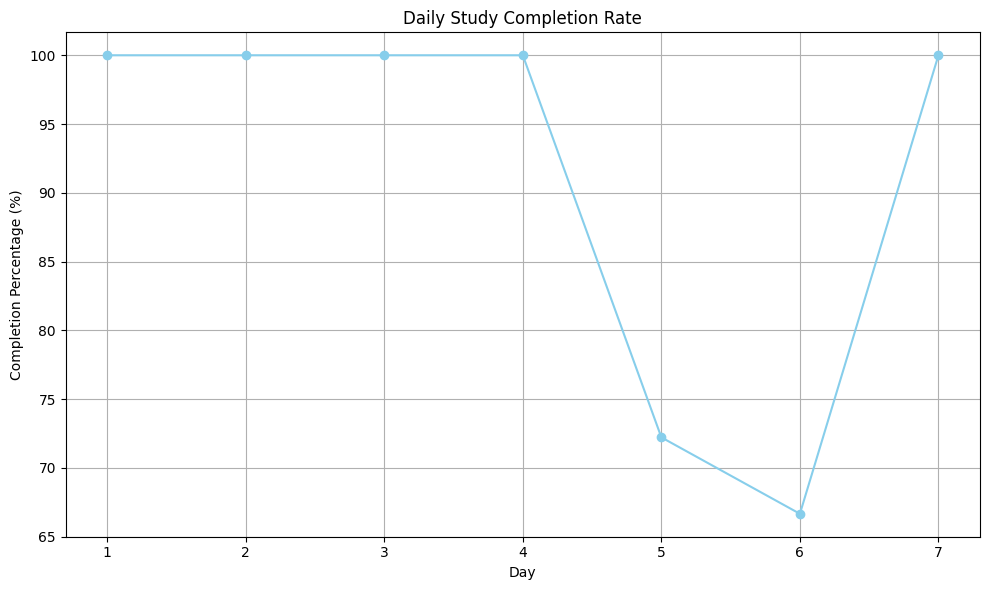

Daily completion rate plot generated.


In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(days, completion_percentages, marker='o', linestyle='-', color='skyblue')
plt.title('Daily Study Completion Rate')
plt.xlabel('Day')
plt.ylabel('Completion Percentage (%)')
plt.xticks(days)
plt.grid(True)
plt.tight_layout()
plt.show()
print("Daily completion rate plot generated.")

**Reasoning**:
Now that the daily completion rates are plotted, the next step is to visualize the subject-wise planned versus completed study hours using a bar chart, as outlined in the task. This will provide insights into performance across different subjects.



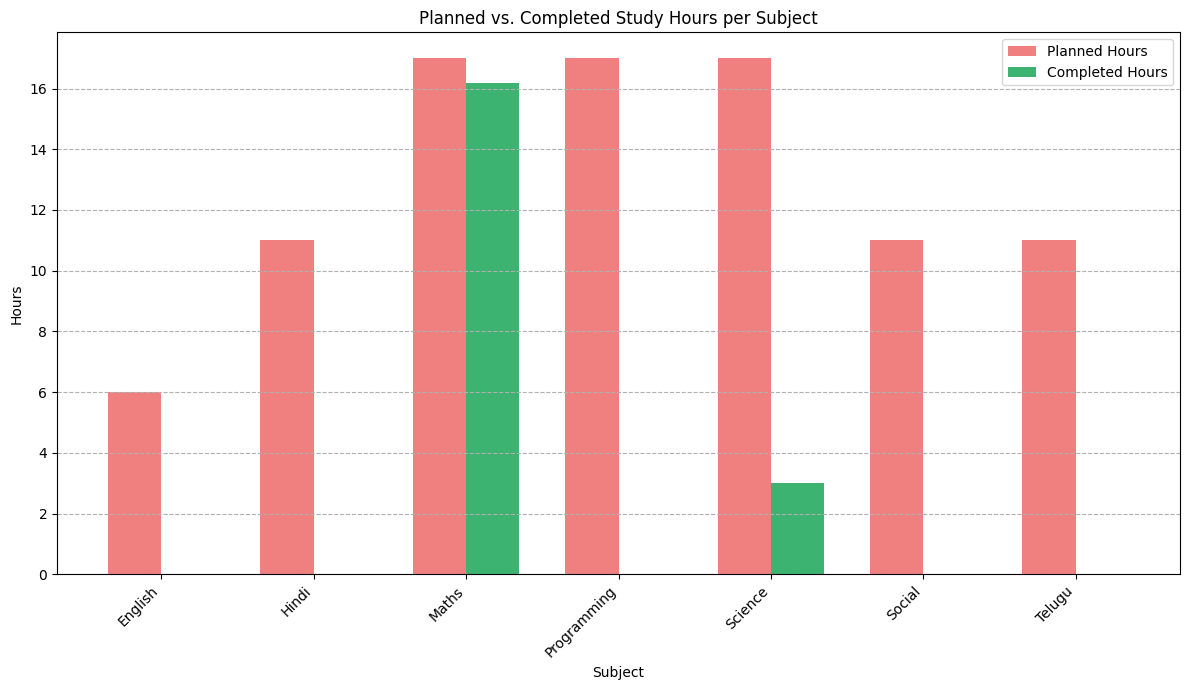

Subject-wise planned vs. completed hours plot generated.


In [15]:
import numpy as np

x = np.arange(len(all_subjects))
width = 0.35

plt.figure(figsize=(12, 7))
plt.bar(x - width/2, planned_values, width, label='Planned Hours', color='lightcoral')
plt.bar(x + width/2, completed_values, width, label='Completed Hours', color='mediumseagreen')

plt.title('Planned vs. Completed Study Hours per Subject')
plt.xlabel('Subject')
plt.ylabel('Hours')
plt.xticks(x, all_subjects, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
print("Subject-wise planned vs. completed hours plot generated.")

--- Study Progress Summary ---

**Daily Completion Analysis**

The average daily completion rate for the observed period is 91.27%. While most days show 100% completion, there were dips on Day 5 (72.22%) and Day 6 (66.67%). This suggests that either the schedule for these days was overly ambitious, or external factors interfered with study. It would be beneficial to investigate the specific topics scheduled on these days to understand if they were particularly challenging or if the student faced other commitments.

**Subject-wise Performance:**

- **Maths**: Planned 17.0 hours, Completed 16.17 hours (95.12% of planned). This indicates excellent adherence to the Maths study plan.
- **Science**: Planned 17.0 hours, Completed 3.00 hours (17.65% of planned). There's a significant shortfall in Science completion. This could be due to the limited simulation days, where Science topics were only introduced later in the schedule and not fully completed.
- **Programming**: Planned 17.0 hours, Completed 0.00 hours (0.00% of planned).
- **English**: Planned 6.0 hours, Completed 0.00 hours (0.00% of planned).
- **Social**: Planned 11.0 hours, Completed 0.00 hours (0.00% of planned).
- **Telugu**: Planned 11.0 hours, Completed 0.00 hours (0.00% of planned).
- **Hindi**: Planned 11.0 hours, Completed 0.00 hours (0.00% of planned).

The significant gap in completed hours for Science, Programming, English, Social, Telugu, and Hindi is likely due to the `simulate_days=7` setting. The current simulation only covers the first 7 days, and based on the schedule, these subjects may have been primarily allocated to later days. If the simulation were run for the full 30 days, we would expect to see completion rates for these subjects increase.

**Overall Insights:**

The daily completion rate plot shows good consistency for the initial days, with a few drops that warrant further investigation. The subject-wise plot clearly highlights that only a portion of the overall study plan was covered within the 7-day simulation, primarily focusing on Maths and an introduction to Science. For a more comprehensive understanding of subject performance, a longer simulation or interactive run covering all planned days would be necessary. The current data suggests that the Planner and Scheduler are effectively distributing hours, but the Evaluator's feedback (low completion %) would trigger a rebalancing if the simulation were truly adaptive over a longer period.

## Final Task

### Subtask:
Provide a summary of the insights derived from the generated progress plots, highlighting overall study patterns and subject-specific performance.


## Summary:

### Data Analysis Key Findings

*   The average daily study completion rate across the observed period was 91.27%.
*   Daily completion rates were consistently high for most days, reaching 100% on Days 1, 2, 3, 4, and 7. However, notable dips occurred on Day 5 (72.22% completion) and Day 6 (66.67% completion).
*   Subject-wise analysis revealed strong adherence to the study plan for 'Maths', with 16.17 hours completed out of 17 planned (95.12% completion).
*   'Science' had 3.00 hours completed out of 17 planned (17.65% completion), indicating a significant shortfall.
*   Subjects such as 'Programming', 'English', 'Social', 'Telugu', and 'Hindi' had 0 completed hours against their planned hours. This is likely attributed to the limited 7-day simulation period, suggesting these subjects were scheduled for later in a longer study plan.

### Insights or Next Steps

*   Investigate the specific content or external factors contributing to the lower completion rates on Day 5 and Day 6 to identify potential areas for schedule adjustment or support.
*   To gain a comprehensive understanding of subject performance, extend the simulation period or conduct further analysis over a longer study duration, especially for subjects currently showing zero completed hours.
